In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
import matplotlib as mpl
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux, align_fluxes_by_reference
from scipy.spatial import cKDTree
import pandas as pd
from multiprocessing.dummy import Pool
from tqdm import tqdm
from astropy.nddata import Cutout2D
import glob
import pickle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set location data
location = '/net/vdesk/data2/deklerk/GAAP_data'

In [5]:
field = '58.9_-48.6'

In [6]:
aperture_size = 4

In [29]:
with open(f'{location}/{field}/aperture_{aperture_size/5}".pkl', 'rb') as f:
    dfs = pickle.load(f)
with open(f'{location}/{field}/sigma_aperture_{aperture_size/5}".pkl', 'rb') as f:
    sigma = pickle.load(f)

In [ ]:
cutout_size = 50
tile_size = 300
dfs = {}
sigma = {}
filters = ['u', 'g', 'r', 'i', 'y', 'z', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
for i, filter in enumerate(filters):
    print(f'Processing filter {filter} ({i+1} of {len(filters)})           ')
    if len(filter) == 1:
        catalog = Table.read(f'{location}/{field}/{filter}.cat', format='ascii')
    else:
        catalog = Table.read(f'{location}/{field}/{filter}.cat', format='fits', hdu=2)
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")][0]
    hdu = fits.open(image_file)[1 if len(filter) == 1 else 0]
    wcs = WCS(hdu.header)
    image_data = hdu.data
    try:
        psf_file = [file for file in files if file.endswith("psf.fits")][0]
        psf = fits.open(psf_file)[0].data
    except Exception:
        print(f'Constructing PSF for {filter} band')
        if filter[:4] == 'DES-':
            mask = (
                (np.log(catalog['FLUX_AUTO']) > 10.5)
                & (np.log(catalog['FLUX_AUTO']) < 12.5)
                & (catalog['FLUX_RADIUS'] > 5)
                & (catalog['FLUX_RADIUS'] < 8.1)
                )
        else:
            mask = (
                (np.log(catalog['FLUX_AUTO']) > 10)
                & (np.log(catalog['FLUX_AUTO']) < 12)
                & (catalog['FLUX_RADIUS'] > 2)
                & (catalog['FLUX_RADIUS'] < 3.3)
            )
        
        
        cutouts = []
        for (x, y) in catalog[mask]['X_IMAGE', 'Y_IMAGE']:
            cutout = Cutout2D(image_data, (x, y), cutout_size, mode='partial', fill_value=np.nan)
            cutouts.append(cutout.data)
        psf = np.nanmean(cutouts, axis=0)
        psf /= np.sum(psf)
    
    if len(filter) == 1:
        # Set the weight function for set aperture size
        weight = gaussian_weight(image_data.shape[0], image_data.shape[1], image_data.shape[0]/2, image_data.shape[1]/2, aperture_size, aperture_size)

        centers = [[xc, yc] for (xc, yc) in catalog['X_IMAGE', 'Y_IMAGE']]

        flux, sigma[filter] = calculate_gaap_flux(image_data, psf, weight, centers)
        
        # Store the data in a dataframe
        ra, dec = wcs.wcs_pix2world(catalog['X_IMAGE'], catalog['Y_IMAGE'], 0)
        df_filter = pd.DataFrame({'ra': ra, 'dec': dec, 'flux': flux})

    else:
        ny, nx = image_data.shape
        # Split image into tiles
        x_edges = np.arange(0, nx + 1, tile_size)
        y_edges = np.arange(0, ny + 1, tile_size)

        df_tiles = []
        sigma_tile_list = []
        conversion_factor = 10**((8.90 - hdu.header['MAGZERO'])/2.5) * 10**9
        image_data *= conversion_factor
        for y_start, y_end in zip(y_edges[:-1], y_edges[1:]):
            for x_start, x_end in zip(x_edges[:-1], x_edges[1:]):
                print(f"Processing x=({x_start},{x_end}), y=({y_start},{y_end})           ", end='\r', flush=True)
                image_cut = image_data[y_start:y_end, x_start:x_end].copy()

                weight = gaussian_weight(
                    image_cut.shape[0],
                    image_cut.shape[1],
                    image_cut.shape[0] / 2,
                    image_cut.shape[1] / 2,
                    aperture_size * 2,
                    aperture_size * 2
                )
                # plt.imshow(psf)
                # plt.scatter([psf.shape[1]/2], [psf.shape[0]/2], c='r')
                # plt.show()
                # plt.imshow(gaussian_weight(psf.shape[0], psf.shape[1], psf.shape[0]/2, psf.shape[1]/2, aperture_size*2, aperture_size*2))
                # plt.scatter([psf.shape[1]/2], [psf.shape[0]/2], c='r')
                # plt.show()
                # break

                mask_tile = (
                    (catalog['X_IMAGE'] >= x_start) & (catalog['X_IMAGE'] < x_end) &
                    (catalog['Y_IMAGE'] >= y_start) & (catalog['Y_IMAGE'] < y_end)
                )
                if np.sum(mask_tile) == 0:
                    continue

                centers = [
                    [xc - x_start, yc - y_start]
                    for (xc, yc) in zip(catalog[mask_tile]['X_IMAGE'], catalog[mask_tile]['Y_IMAGE'])
                ]

                flux, sigma_tile = calculate_gaap_flux(image_cut, psf, weight, centers)
                sigma_tile_list.append(sigma_tile)

                ra, dec = wcs.wcs_pix2world(
                    catalog[mask_tile]['X_IMAGE'],
                    catalog[mask_tile]['Y_IMAGE'],
                    0
                )
                df_tile = pd.DataFrame({
                    'ra': ra,
                    'dec': dec,
                    'flux': flux,
                    'star': np.array(catalog[mask_tile]['CLASS_STAR'])
                })
                df_tiles.append(df_tile)

        sigma[filter] = np.mean(sigma_tile_list)
        df_filter = pd.concat(df_tiles, ignore_index=True)
    dfs[filter] = df_filter



Processing filter u (1 of 12)           
Processing filter g (2 of 12)           
Processing filter r (3 of 12)           
Processing filter i (4 of 12)           
Processing filter y (5 of 12)           
Processing filter z (6 of 12)           
Processing filter DES-G (7 of 12)           
Constructing PSF for DES-G band
Processing filter DES-R (8 of 12)                     
Constructing PSF for DES-R band
Processing filter DES-I (9 of 12)                     
Constructing PSF for DES-I band
Processing filter NIR-Y (10 of 12)                    
Constructing PSF for NIR-Y band
Processing filter NIR-J (11 of 12)                    
Constructing PSF for NIR-J band
Processing filter NIR-H (12 of 12)                    
Constructing PSF for NIR-H band


In [7]:
with open(f'{location}/{field}/aperture_{aperture_size/5}".pkl', 'rb') as f:
    dfs = pickle.load(f)

In [9]:
def align_fluxes_by_reference(dfs, max_dist=2.0):
    # Find reference catalog (smallest)
    ref_band = min(dfs, key=lambda k: len(dfs[k]))
    ref_df = dfs[ref_band]
    ra_ref = ref_df['ra'].values
    dec_ref = ref_df['dec'].values
    ref_points = np.column_stack((ra_ref, dec_ref))

    bands = list(dfs.keys())
    flux_list = []

    for band in bands:
        df = dfs[band]
        ra = df['ra'].values
        dec = df['dec'].values
        points = np.column_stack((ra, dec))

        # Build KDTree and query nearest neighbor for each reference point
        tree = cKDTree(points)
        dist, idx = tree.query(ref_points, distance_upper_bound=max_dist)

        # Initialize flux array with NaNs
        flux_aligned = np.full(len(ref_points), np.nan)

        # Fill only valid matches
        valid = idx < len(df)
        flux_aligned[valid] = df['flux'].values[idx[valid]]

        flux_list.append(flux_aligned)

    # Combine into 2D array: rows = galaxies, columns = filters
    flux_matrix = np.column_stack(flux_list)
    return bands, flux_matrix

In [91]:
new_dfs = {}
for (band, df) in dfs.items():
    if len(band) > 1:
        new_dfs[band] = df[df['star']>=0.1]


In [10]:
print(new_dfs.keys())

dict_keys(['DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H'])


In [36]:
bands, flux_matrix = align_fluxes_by_reference(dfs, max_dist=1/3600)
print(bands)
print(flux_matrix.shape)
print(flux_matrix)

['u', 'g', 'r', 'i', 'y', 'z', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
(611, 12)
[[4.70995565e+02 4.76316170e+03 1.29542453e+04 ... 2.77170746e+02
  3.51377426e+02 4.75474722e+02]
 [8.41715131e+01 2.81042651e+02 5.18015067e+02 ... 2.50481597e+02
  2.59423522e+02 2.37757880e+02]
 [2.33496530e+01 4.99634811e+01 7.98491197e+01 ... 3.68696916e+01
  4.16450686e+01 4.62941642e+01]
 ...
 [1.11970360e+01            nan            nan ...            nan
             nan            nan]
 [1.33656683e+01 2.08862097e+01 3.82847857e+01 ... 1.58208312e+01
  1.93255739e+01 1.98898213e+01]
 [9.00966341e+00            nan            nan ...            nan
             nan            nan]]


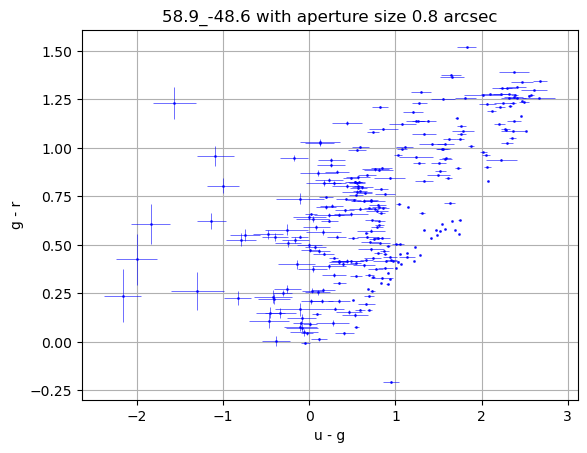

In [13]:
filter_1 = 0
filter_2 = 1
filter_3 = 1
filter_4 = 2


with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_3]/flux_matrix[:,filter_4])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_1]]/flux_matrix[:,filter_1])**2+(sigma[bands[filter_2]]/flux_matrix[:,filter_2])**2)
    yerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_3]]/flux_matrix[:,filter_3])**2+(sigma[bands[filter_4]]/flux_matrix[:,filter_4])**2)

    # xerr = np.zeros_like(x_color) 
    # yerr = np.zeros_like(y_color)
    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    plt.title(f'{field} with aperture size {aperture_size/5} arcsec')
    # plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_3]} - {bands[filter_4]}')
    plt.show()

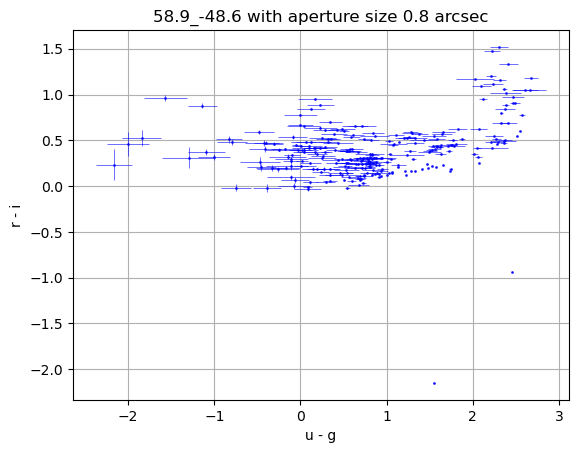

In [24]:
filter_1 = 0
filter_2 = 1
filter_3 = 2
filter_4 = 3


with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_3]/flux_matrix[:,filter_4])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_1]]/flux_matrix[:,filter_1])**2+(sigma[bands[filter_2]]/flux_matrix[:,filter_2])**2)
    yerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_3]]/flux_matrix[:,filter_3])**2+(sigma[bands[filter_4]]/flux_matrix[:,filter_4])**2)

    # xerr = np.zeros_like(x_color) 
    # yerr = np.zeros_like(y_color)
    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    plt.title(f'{field} with aperture size {aperture_size/5} arcsec')
    # plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_3]} - {bands[filter_4]}')
    plt.show()

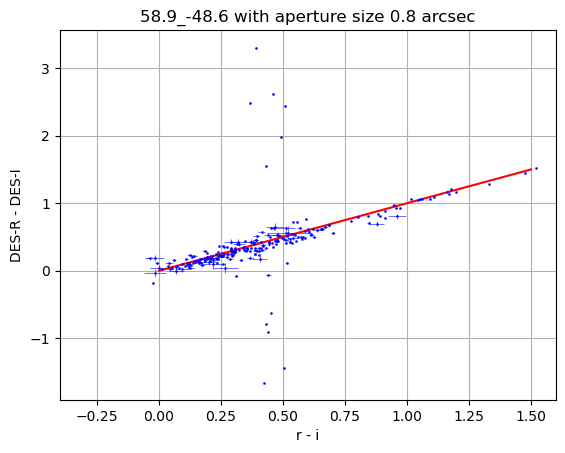

In [37]:
filter_1 = 2
filter_2 = 3
filter_3 = 7
filter_4 = 8

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_3]/flux_matrix[:,filter_4])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_1]]/flux_matrix[:,filter_1])**2+(sigma[bands[filter_2]]/flux_matrix[:,filter_2])**2)
    yerr = 2.5/np.log(10)*np.sqrt((sigma[bands[filter_3]]/flux_matrix[:,filter_3])**2+(sigma[bands[filter_4]]/flux_matrix[:,filter_4])**2)
    mask = (xerr**2 + yerr**2 < np.inf)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    plt.title(f'{field} with aperture size {aperture_size/5} arcsec')
    plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_3]} - {bands[filter_4]}')
    plt.xlim(-0.4, 1.6)
    # plt.ylim(-0.5, 1.5)
    plt.plot([0, 1.5], [0, 1.5], c='r')
    # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')
    plt.show()

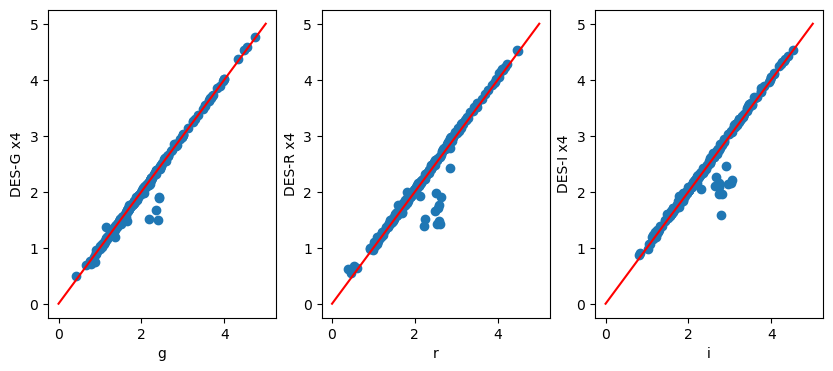

In [45]:
filter_1 = 1
filter_2 = 6
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    mask = ~np.isnan(flux_matrix[:,i+1]) & ~np.isnan(flux_matrix[:,i+6]) & (flux_matrix[:,i]>0) & (flux_matrix[:,i+6]>0)
    axes[i].scatter(np.log10(flux_matrix[mask,i+1]),np.log10(4*flux_matrix[mask,i+6]))
    axes[i].set_xlabel(bands[i+1])
    axes[i].set_ylabel(bands[i+6] + ' x4')
    axes[i].plot([0, 5], [0, 5], c='r')
plt.show()

In [75]:
with open(f'{location}/{field}/aperture_{aperture_size/5}".pkl', 'wb') as f:
    pickle.dump(dfs, f)
with open(f'{location}/{field}/sigma_aperture_{aperture_size/5}".pkl', 'wb') as f:
    pickle.dump(sigma, f)